**TLDR:**

I compared Knowledge Graph-based RAG with non-KG methods on key recall metrics after reading a Microsoft paper on GraphRAG that used vaguely defined metrics without quantifiable improvements, prompting me to test knowledge graph performance with neo4j, and considering Microsoft's potential vested interest in promoting ROI improvements and now Nvidia's competing GraphRAG product.

**Context:**

After reading a paper created by Microsoft on GraphRAG that did not address many reasons to use the increased amount of engineering and compute needed for GraphRAG (especially if documents are dynamic), I wanted to see how knowledge graphs perform (I enjoy knowledge graphs, but maybe there was something useful here to justify a large increase in engineering to utilize RAG, maybe not).

I found the Microsoft paper (link below) uses metrics that are vaguely defined (Comprehensiveness, Diversity, and Empowerment), without referencing any quantifiable lift other than noting "substantial improvements over the naive RAG baseline".  

Since Microsoft did not divulge their proprietary GraphRAG method that shows vaguely defined metrics to increase by unknown amounts (that may or may not justify increased compute), I felt obliged to see how a knowledge graph performs using RAG with neo4j (a technically I've used recently for other reasons).

Microsoft as a public company would have a vested interest in publishing whitepapers and case studies for ROI improvements on GraphRAG in near future, which after seeing these results I'm not sure would be devoid of theoretical presumptions on advances in NLP technology.

Also noting Nvidia started a GraphRAG product of their own and based on the positioning it appears that it is to to compete with Microsoft with this, but possibly due to other reasons of course.

So how does GraphRAG perform?

---

**Methodology:**

1. Split a document into chunks using RecursiveCharacterTextSplitter (the document is the June 2024 US Presidential Debate transcript, since a model cannot be trained on the doc).


2. Loaded the document into Neo4j using its graphical representation of the semantic values it finds and index the result


3. Created 3 retrievers to use as variants to test on the same chunked document: one that uses the Neo4j knowledge graph AND the Neo4j index, another that uses the Neo4j knowledge graph but WITHOUT reference to the Neo4j index, and a FAISS retriever baseline that loads the same document without ANY reference to Neo4j. 


4. Created Ground Truth Q&A dataset for evals for N = 10 and N = 100 to see direction of any variance with increasing N


5. Used RAGAS to compare the results across 4 of the primary metrics from RAGAS (primarily precision and recall of the retrieval as well as the overall answer) that the Microsoft paper appears to have not utilized while sharing their findings.


6. Plotted the results (for both N = 10 and N = 100)

---
**Microsoft GraphRAG paper I'm referring to:** 

https://arxiv.org/pdf/


### Step 1: Chunking the RAG content, Ingestion into Neo4j and setting up 3 retrievers

In [24]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [120]:
# Import packages
import os
import asyncio 
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
from dotenv import load_dotenv
from typing import List, Dict, Union
from scipy import stats
from collections import OrderedDict
import openai
from langchain_openai import OpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter
from langchain_community.vectorstores import Neo4jVector, FAISS
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document
from neo4j import GraphDatabase 
import numpy as np
import matplotlib.pyplot as plt
#from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
)
from datasets import Dataset
import random

In [26]:
# Set up API keys 
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
neo4j_url = os.getenv("NEO4J_URL")
neo4j_user = os.getenv("NEO4J_USER")
neo4j_password = os.getenv("NEO4J_PASSWORD")
openai_api_key = os.getenv("OPENAI_API_KEY") # changed keys - ignore

In [27]:
# Load and process the PDF
pdf_path = "debate_transcript.pdf"
loader = PyPDFLoader(pdf_path)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # Comparable to Neo4j
texts = text_splitter.split_documents(documents)

In [28]:
# Set up Neo4j connection
driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))


In [29]:
# Define model for retrieval 
llm = ChatOpenAI(model_name="gpt-3.5-turbo", openai_api_key=openai_api_key)

In [19]:
# Create function for vector index in Neo4j after the graph representation is complete below
def create_vector_index(tx):
    query = """
    CREATE VECTOR INDEX pdf_content_index IF NOT EXISTS
    FOR (c:Content)
    ON (c.embedding)
    OPTIONS {indexConfig: {
      `vector.dimensions`: 1536,
      `vector.similarity_function`: 'cosine'
    }}
    """
    tx.run(query)

In [21]:
# Function for Neo4j graph creation
def create_document_graph(tx, texts, pdf_name):
    query = """
    MERGE (d:Document {name: $pdf_name})
    WITH d
    UNWIND $texts AS text
    CREATE (c:Content {text: text.page_content, page: text.metadata.page})
    CREATE (d)-[:HAS_CONTENT]->(c)
    WITH c, text.page_content AS content
    UNWIND split(content, ' ') AS word
    MERGE (w:Word {value: toLower(word)})
    MERGE (c)-[:CONTAINS]->(w)
    """
    tx.run(query, pdf_name=pdf_name, texts=[
        {"page_content": t.page_content, "metadata": t.metadata}
        for t in texts
    ])

In [23]:
# Create graph index and structure
with driver.session() as session:
    session.execute_write(create_vector_index)
    session.execute_write(create_document_graph, texts, pdf_path)



In [24]:
# Close driver
driver.close()

In [16]:
# Setup embeddings model w default OAI embeddings 
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [32]:
# Neo4j retriever setup using Neo4j, OAI embeddings model using Neo4j index 
neo4j_vector_store = Neo4jVector.from_existing_index(
    embeddings,
    url=neo4j_url,
    username=neo4j_user,
    password=neo4j_password,
    index_name="pdf_content_index",
    node_label="Content",
    text_node_property="text",
    embedding_node_property="embedding"
)
neo4j_retriever = neo4j_vector_store.as_retriever(search_kwargs={"k": 2})

In [31]:
# OpenAI retriever setup using Neo4j, OAI embeddings model NOT using Neo4j index 
openai_vector_store = Neo4jVector.from_documents(
    texts,
    embeddings,
    url=neo4j_url,
    username=neo4j_user,
    password=neo4j_password
)
openai_retriever = openai_vector_store.as_retriever(search_kwargs={"k": 2})

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('db.create.setVectorProperty' has been replaced by 'db.create.setNodeVectorProperty')} {position: line: 1, column: 80, offset: 79} for query: "UNWIND $data AS row CALL { WITH row MERGE (c:`Chunk` {id: row.id}) WITH c, row CALL db.create.setVectorProperty(c, 'embedding', row.embedding) YIELD node SET c.`text` = row.text SET c += row.metadata } IN TRANSACTIONS OF 1000 ROWS"


In [35]:
# FAISS retriever setup - OAI embeddings model baseline for non Neo4j vector store touchpoint
faiss_vector_store = FAISS.from_documents(texts, embeddings)
faiss_retriever = faiss_vector_store.as_retriever(search_kwargs={"k": 2})

### Step 2: Creating ground truth for RAGAS eval

In [36]:
# Start w N = 10 before moving to N = 100
def create_ground_truth(texts: List[str], num_questions: int = 10) -> List[Dict]:
    llm_ground_truth = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)  # Using a higher temperature for more diverse outputs
    
    ground_truth = []
    
    # 1. Generate questions
    question_prompt = ChatPromptTemplate.from_template(
        "Given the following text, generate {num_questions} diverse and specific questions that can be answered based on the information in the text. "
        "Provide the questions as a numbered list.\n\nText: {text}\n\nQuestions:"
    )
    
    all_questions = []
    for text in texts:
        response = llm_ground_truth(question_prompt.format_messages(num_questions=num_questions, text=text))
        questions = response.content.strip().split('\n')
        all_questions.extend([q.split('. ', 1)[1] if '. ' in q else q for q in questions])
    
    # Shuffle and select questions
    random.shuffle(all_questions)
    selected_questions = all_questions[:num_questions]
    
    # 2. Generate answers and context for each question, using original model
    for question in selected_questions:
        # Generate answer
        answer_prompt = ChatPromptTemplate.from_template(
            "Given the following question, provide a concise and accurate answer based on the information available in the original texts. "
            "If the answer is not directly available, respond with 'Information not available in the given context.'\n\nQuestion: {question}\n\nAnswer:"
        )
        answer_response = llm(answer_prompt.format_messages(question=question))
        answer = answer_response.content.strip()
        
        # Generate relevant context
        context_prompt = ChatPromptTemplate.from_template(
            "Given the following question and answer, provide the most relevant excerpt from the original texts that supports this answer. "
            "If no relevant context is available, respond with 'No relevant context available.'\n\n"
            "Question: {question}\nAnswer: {answer}\n\nRelevant context:"
        )
        context_response = llm(context_prompt.format_messages(question=question, answer=answer))
        context = context_response.content.strip()
        
        ground_truth.append({
            "question": question,
            "answer": answer,
            "context": context,
        })
    
    return ground_truth



In [82]:
def create_ground_truth(texts: List[Union[str, Document]], num_questions: int = 10) -> List[Dict]:
    llm_ground_truth = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)
    
    # Function to extract text from str or Document
    def get_text(item):
        if isinstance(item, Document):
            return item.page_content
        return item
    
    # Split long texts into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_text(' '.join(get_text(doc) for doc in texts))
    
    ground_truth = []
    
    question_prompt = ChatPromptTemplate.from_template(
        "Given the following text, generate {num_questions} diverse and specific questions that can be answered based on the information in the text. "
        "Provide the questions as a numbered list.\n\nText: {text}\n\nQuestions:"
    )
    
    all_questions = []
    for split in all_splits:
        response = llm_ground_truth(question_prompt.format_messages(num_questions=3, text=split))
        questions = response.content.strip().split('\n')
        all_questions.extend([q.split('. ', 1)[1] if '. ' in q else q for q in questions])
    
    random.shuffle(all_questions)
    selected_questions = all_questions[:num_questions]
    
    llm = ChatOpenAI(temperature=0)
    
    for question in selected_questions:
        answer_prompt = ChatPromptTemplate.from_template(
            "Given the following question, provide a concise and accurate answer based on the information available. "
            "If the answer is not directly available, respond with 'Information not available in the given context.'\n\nQuestion: {question}\n\nAnswer:"
        )
        answer_response = llm(answer_prompt.format_messages(question=question))
        answer = answer_response.content.strip()
        
        context_prompt = ChatPromptTemplate.from_template(
            "Given the following question and answer, provide a brief, relevant context that supports this answer. "
            "If no relevant context is available, respond with 'No relevant context available.'\n\n"
            "Question: {question}\nAnswer: {answer}\n\nRelevant context:"
        )
        context_response = llm(context_prompt.format_messages(question=question, answer=answer))
        context = context_response.content.strip()
        
        ground_truth.append({
            "question": question,
            "answer": answer,
            "context": context,
        })
    
    return ground_truth

In [ ]:
# Create ground truth on the document currently chunked
ground_truth = create_ground_truth(texts)


In [148]:
# Print the first few items to verify ground truth
for item in ground_truth[:2]:
    print(f"Question: {item['question']}")
    print(f"Answer: {item['answer']}")
    print(f"Context: {item['context']}")
    print()

Question: What specific changes were made to border security and immigration policy under Biden's administration to alleviate safety and security concerns at the southern border?
Answer: Information not available in the given context.
Context: No relevant context available.

Question: What specific actions has the current administration taken to address the opioid crisis and provide treatment for Americans struggling with addiction?
Answer: The current administration has taken steps such as increasing funding for addiction treatment, expanding access to medication-assisted treatment, and implementing initiatives to reduce opioid prescriptions.
Context: The current administration has made combating the opioid crisis a priority due to the significant impact it has had on communities across the country. With rising rates of opioid addiction and overdose deaths, there has been a push to increase funding for addiction treatment programs to help those struggling with substance abuse. Additio

In [129]:
# Move to N = 100 for more Q&A ground truth
def create_ground_truth2(texts: List[Union[str, Document]], num_questions: int = 100) -> List[Dict]:
    llm_ground_truth = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)
    
    # Function to extract text from str or Document
    def get_text(item):
        if isinstance(item, Document):
            return item.page_content
        return item
    
    # Split long texts into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_text(' '.join(get_text(doc) for doc in texts))
    
    ground_truth2 = []
    
    question_prompt = ChatPromptTemplate.from_template(
        "Given the following text, generate {num_questions} diverse and specific questions that can be answered based on the information in the text. "
        "Provide the questions as a numbered list.\n\nText: {text}\n\nQuestions:"
    )
    
    all_questions = []
    for split in all_splits:
        response = llm_ground_truth(question_prompt.format_messages(num_questions=3, text=split))
        questions = response.content.strip().split('\n')
        all_questions.extend([q.split('. ', 1)[1] if '. ' in q else q for q in questions])
    
    random.shuffle(all_questions)
    selected_questions = all_questions[:num_questions]
    
    llm = ChatOpenAI(temperature=0)
    
    for question in selected_questions:
        answer_prompt = ChatPromptTemplate.from_template(
            "Given the following question, provide a concise and accurate answer based on the information available. "
            "If the answer is not directly available, respond with 'Information not available in the given context.'\n\nQuestion: {question}\n\nAnswer:"
        )
        answer_response = llm(answer_prompt.format_messages(question=question))
        answer = answer_response.content.strip()
        
        context_prompt = ChatPromptTemplate.from_template(
            "Given the following question and answer, provide a brief, relevant context that supports this answer. "
            "If no relevant context is available, respond with 'No relevant context available.'\n\n"
            "Question: {question}\nAnswer: {answer}\n\nRelevant context:"
        )
        context_response = llm(context_prompt.format_messages(question=question, answer=answer))
        context = context_response.content.strip()
        
        ground_truth2.append({
            "question": question,
            "answer": answer,
            "context": context,
        })
    
    return ground_truth2

In [131]:
ground_truth2 = create_ground_truth2(texts)

In [132]:
# Print the first few items to verify ground truth
for item in ground_truth2[:2]:
    print(f"Question: {item['question']}")
    print(f"Answer: {item['answer']}")
    print(f"Context: {item['context']}")
    print()

Question: What progress has been made in terms of small black businesses during President Biden's tenure, according to the text?
Answer: Information not available in the given context.
Context: No relevant context available.

Question: What specific actions did President Biden propose to make child care more affordable?
Answer: President Biden proposed a plan to cap child care costs at 7% of income for families earning up to 1.5 times their state's median income.
Context: President Biden's proposal to cap child care costs at 7% of income for families earning up to 1.5 times their state's median income is part of his broader efforts to address the rising costs of child care in the United States. This plan aims to make child care more affordable and accessible for working families, particularly those with lower to moderate incomes who may struggle to afford quality child care services. By capping costs at a percentage of income, President Biden hopes to alleviate the financial burden on 

### Step 3: Creating a RAG chain for each retrieval method 

In [60]:
# One standardized RAG chain for each retrieval method
def create_rag_chain(retriever):
    template = """Answer the question based on the following context:
    {context}
    
    Question: {question}
    Answer:"""
    prompt = PromptTemplate.from_template(template)
    
    return (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

In [61]:
# Calling the function for each method
neo4j_rag_chain = create_rag_chain(neo4j_retriever)
faiss_rag_chain = create_rag_chain(faiss_retriever)
openai_rag_chain = create_rag_chain(openai_retriever)

### Step 4: Evaluation using RAGAS

In [96]:
# Eval function for RAGAS - start this with N = 10 (using ground_truth)
async def evaluate_rag_async(rag_chain, ground_truth, name):
    splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=50)

    generated_answers = []
    for item in ground_truth:
        question = splitter.split_text(item["question"])[0]

        try:
            answer = await rag_chain.ainvoke(question)
        except AttributeError:
            answer = rag_chain.invoke(question)

        truncated_answer = splitter.split_text(str(answer))[0]
        truncated_context = splitter.split_text(item["context"])[0]
        truncated_ground_truth = splitter.split_text(item["answer"])[0]

        generated_answers.append({
            "question": question,
            "answer": truncated_answer,
            "contexts": [truncated_context],
            "ground_truth": truncated_ground_truth
        })

    dataset = Dataset.from_pandas(pd.DataFrame(generated_answers))

    result = evaluate(
        dataset,
        metrics=[
            context_relevancy,
            faithfulness,
            answer_relevancy,
            context_recall,
        ]
    )

    return {name: result}

async def run_evaluations(rag_chains, ground_truth):
    results = {}
    for name, chain in rag_chains.items():
        result = await evaluate_rag_async(chain, ground_truth, name)
        results.update(result)
    return results

def main(ground_truth, rag_chains):
    # Get event loop
    loop = asyncio.get_event_loop()
    
    # Run evaluations
    results = loop.run_until_complete(run_evaluations(rag_chains, ground_truth))
    
    return results

In [97]:
# Run main function for N = 10
if __name__ == "__main__":

    rag_chains = {
        "Neo4j": neo4j_rag_chain,
        "FAISS": faiss_rag_chain,
        "OpenAI": openai_rag_chain
    }

    results = main(ground_truth, rag_chains)
    
    for name, result in results.items():
        print(f"Results for {name}:")
        print(result)
        print()

Evaluating: 100%|███████████████████████████████| 40/40 [00:14<00:00,  2.69it/s]

Results for Neo4j:
{'context_relevancy': 0.6467, 'faithfulness': 0.4821, 'answer_relevancy': 0.5786, 'context_recall': 0.7000}

Results for FAISS:
{'context_relevancy': 0.6467, 'faithfulness': 0.2519, 'answer_relevancy': 0.6551, 'context_recall': 0.7000}

Results for OpenAI:
{'context_relevancy': 0.6967, 'faithfulness': 0.2250, 'answer_relevancy': 0.8404, 'context_recall': 0.7000}



In [147]:
# Results for N = 10
results

{'Neo4j': {'context_relevancy': 0.6467,
  'faithfulness': 0.4821,
  'answer_relevancy': 0.5786,
  'context_recall': 0.7},
 'FAISS': {'context_relevancy': 0.6467,
  'faithfulness': 0.2519,
  'answer_relevancy': 0.6551,
  'context_recall': 0.7},
 'OpenAI': {'context_relevancy': 0.6967,
  'faithfulness': 0.225,
  'answer_relevancy': 0.8404,
  'context_recall': 0.7}}

In [133]:
# Eval function for RAGAS at N = 100
async def evaluate_rag_async2(rag_chain, ground_truth2, name):
    splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=50)

    generated_answers = []
    for item in ground_truth2:
        question = splitter.split_text(item["question"])[0]

        try:
            answer = await rag_chain.ainvoke(question)
        except AttributeError:
            answer = rag_chain.invoke(question)

        truncated_answer = splitter.split_text(str(answer))[0]
        truncated_context = splitter.split_text(item["context"])[0]
        truncated_ground_truth = splitter.split_text(item["answer"])[0]

        generated_answers.append({
            "question": question,
            "answer": truncated_answer,
            "contexts": [truncated_context],
            "ground_truth": truncated_ground_truth
        })

    dataset = Dataset.from_pandas(pd.DataFrame(generated_answers))

    result = evaluate(
        dataset,
        metrics=[
            context_relevancy,
            faithfulness,
            answer_relevancy,
            context_recall,
        ]
    )

    return {name: result}

async def run_evaluations(rag_chains, ground_truth2):
    results = {}
    for name, chain in rag_chains.items():
        result = await evaluate_rag_async(chain, ground_truth2, name)
        results.update(result)
    return results

def main(ground_truth2, rag_chains):
    # Get event loop
    loop = asyncio.get_event_loop()
    
    # Run evaluations
    results = loop.run_until_complete(run_evaluations(rag_chains, ground_truth2))
    
    return results

In [134]:
# Run main function for N = 100
if __name__ == "__main__":

    rag_chains = {
        "Neo4j": neo4j_rag_chain,
        "FAISS": faiss_rag_chain,
        "OpenAI": openai_rag_chain
    }

    results = main(ground_truth2, rag_chains)
    
    for name, result in results.items():
        print(f"Results for {name}:")
        print(result)
        print()

Evaluating: 100%|█████████████████████████████| 400/400 [01:03<00:00,  6.28it/s]


Results for Neo4j:
{'context_relevancy': 0.7358, 'faithfulness': 0.5237, 'answer_relevancy': 0.7391, 'context_recall': 0.6450}

Results for FAISS:
{'context_relevancy': 0.7342, 'faithfulness': 0.1951, 'answer_relevancy': 0.8722, 'context_recall': 0.6550}

Results for OpenAI:
{'context_relevancy': 0.7417, 'faithfulness': 0.2093, 'answer_relevancy': 0.9322, 'context_recall': 0.6450}



In [141]:
# show raw results for N = 100 
print(results)

{'Neo4j': {'context_relevancy': 0.7358, 'faithfulness': 0.5237, 'answer_relevancy': 0.7391, 'context_recall': 0.6450}, 'FAISS': {'context_relevancy': 0.7342, 'faithfulness': 0.1951, 'answer_relevancy': 0.8722, 'context_recall': 0.6550}, 'OpenAI': {'context_relevancy': 0.7417, 'faithfulness': 0.2093, 'answer_relevancy': 0.9322, 'context_recall': 0.6450}}


### Step 5: Plot Results for N = 10

In [160]:
# Results from above for N = 10
results = {'Neo4j': {'context_relevancy': 0.6467,
  'faithfulness': 0.4821,
  'answer_relevancy': 0.5786,
  'context_recall': 0.7},
 'FAISS': {'context_relevancy': 0.6467,
  'faithfulness': 0.2519,
  'answer_relevancy': 0.6551,
  'context_recall': 0.7},
 'OpenAI': {'context_relevancy': 0.6967,
  'faithfulness': 0.225,
  'answer_relevancy': 0.8404,
  'context_recall': 0.7}}

In [99]:
# first set of results for N = 10 - using ground_truth and not ground_truth2 in the above code
results

{'Neo4j': {'context_relevancy': 0.6467, 'faithfulness': 0.4821, 'answer_relevancy': 0.5786, 'context_recall': 0.7000},
 'FAISS': {'context_relevancy': 0.6467, 'faithfulness': 0.2519, 'answer_relevancy': 0.6551, 'context_recall': 0.7000},
 'OpenAI': {'context_relevancy': 0.6967, 'faithfulness': 0.2250, 'answer_relevancy': 0.8404, 'context_recall': 0.7000}}

In [150]:
# Function to plot, with error estimates for N = 10 rather than CI.  CI is used for N = 100 below
def plot_results(results):
    name_mapping = {
        'Neo4j': 'Neo4j with its own index',
        'OpenAI': 'Neo4j without using Neo4j index',
        'FAISS': 'FAISS vector db (not knowledge graph)'
    }
    
    # Create a new OrderedDict
    ordered_results = OrderedDict()
    ordered_results['Neo4j with its own index'] = results['Neo4j']
    ordered_results['Neo4j without using Neo4j index'] = results['OpenAI']
    ordered_results['Non-Neo4j FAISS vector db'] = results['FAISS']
    
    metrics = list(next(iter(ordered_results.values())).keys())
    chains = list(ordered_results.keys())
    
    fig, ax = plt.subplots(figsize=(18, 10))  
    
    bar_width = 0.25
    opacity = 0.8
    index = np.arange(len(metrics))
    
    for i, chain in enumerate(chains):
        means = [ordered_results[chain][metric] for metric in metrics]
        
        all_values = list(ordered_results[chain].values())
        error = (max(all_values) - min(all_values)) / 2
        yerr = [error] * len(means)
        
        bars = ax.bar(index + i*bar_width, means, bar_width,
               alpha=opacity,
               color=plt.cm.Set3(i / len(chains)),
               label=chain,
               yerr=yerr,
               capsize=5)
        
       
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',  # Changed to 2 decimal places
                    ha='center', va='bottom', rotation=0, fontsize=18, fontweight='bold')
    
    ax.set_xlabel('RAGAS Metrics', fontsize=16)
    ax.set_ylabel('Scores', fontsize=16)
    ax.set_title('RAGAS Evaluation Results with Error Estimates', fontsize=26, fontweight='bold')
    ax.set_xticks(index + bar_width * (len(chains) - 1) / 2)
    ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=14, fontweight='bold')
    
    ax.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1), ncol=1)
    
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


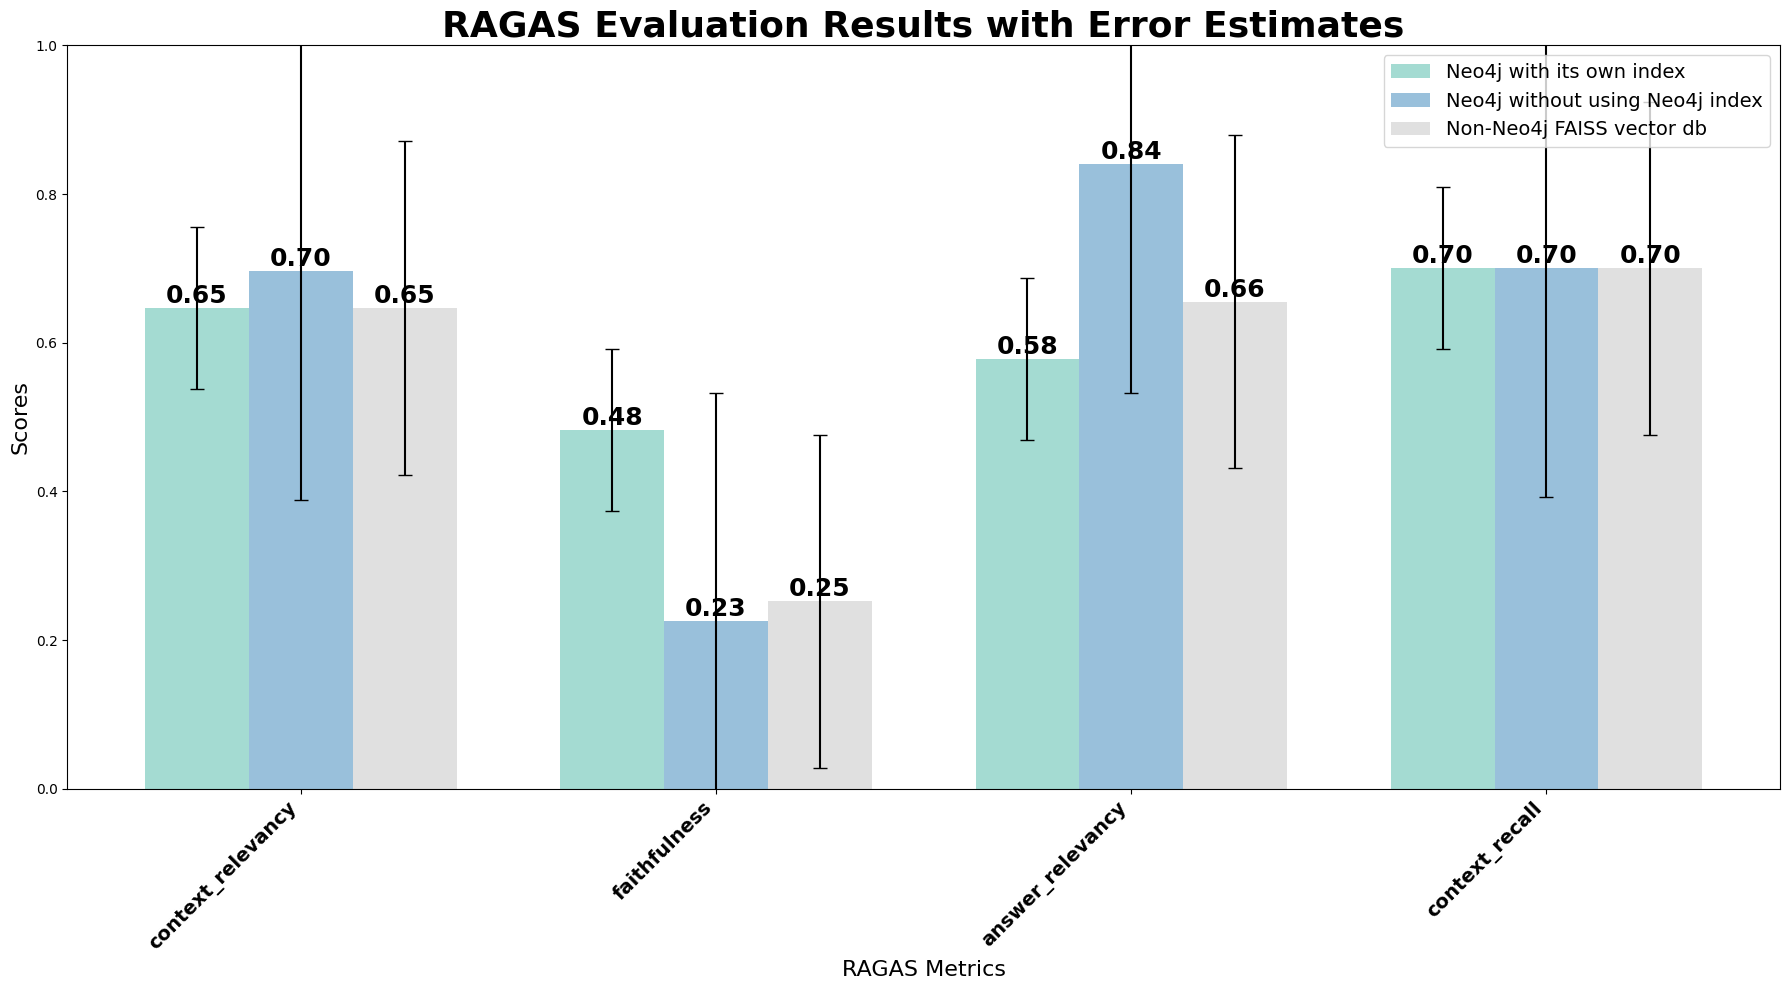

In [151]:
# Plot
plot_results(results)

### Step 6: Plot Results for N = 100

In [186]:
results = {'Neo4j': {'context_relevancy': 0.7358, 'faithfulness': 0.5237, 'answer_relevancy': 0.7391, 'context_recall': 0.6450}, 'FAISS': {'context_relevancy': 0.7342, 'faithfulness': 0.1951, 'answer_relevancy': 0.8722, 'context_recall': 0.6550}, 'OpenAI': {'context_relevancy': 0.7417, 'faithfulness': 0.2093, 'answer_relevancy': 0.9322, 'context_recall': 0.6450}}

In [187]:
results 

{'Neo4j': {'context_relevancy': 0.7358,
  'faithfulness': 0.5237,
  'answer_relevancy': 0.7391,
  'context_recall': 0.645},
 'FAISS': {'context_relevancy': 0.7342,
  'faithfulness': 0.1951,
  'answer_relevancy': 0.8722,
  'context_recall': 0.655},
 'OpenAI': {'context_relevancy': 0.7417,
  'faithfulness': 0.2093,
  'answer_relevancy': 0.9322,
  'context_recall': 0.645}}

In [189]:
# Plot CI - low sample size due to Q&A constraint at 100
def bootstrap_ci(data, num_bootstraps=1000, ci=0.95):
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_bootstraps)]
    return np.percentile(bootstrapped_means, [(1-ci)/2 * 100, (1+ci)/2 * 100])

In [198]:
# Function to plot for N = 100, with CI @ 95% if this were a list but it is not
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def bootstrap_ci(data, num_bootstraps=1000, ci=0.95):
    if isinstance(data, (int, float)):
        return data, data  # Return the same value for both CI bounds due to it being one number
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_bootstraps)]
    return np.percentile(bootstrapped_means, [(1-ci)/2 * 100, (1+ci)/2 * 100])

def plot_results(results):
    name_mapping = {
        'Neo4j': 'Neo4j with its own index',
        'OpenAI': 'Neo4j without using Neo4j index',
        'FAISS': 'FAISS vector db (not knowledge graph)'
    }
    
    # Create a new OrderedDict 
    ordered_results = OrderedDict()
    ordered_results['Neo4j with its own index'] = results['Neo4j']
    ordered_results['Neo4j without using Neo4j index'] = results['OpenAI']
    ordered_results['Non-Neo4j FAISS vector db'] = results['FAISS']
    
    metrics = list(next(iter(ordered_results.values())).keys())
    chains = list(ordered_results.keys())
    
    fig, ax = plt.subplots(figsize=(18, 10)) 
    
    bar_width = 0.25
    opacity = 0.8
    index = np.arange(len(metrics))
    
    for i, chain in enumerate(chains):
        means = [ordered_results[chain][metric] for metric in metrics]
        
        # Calculate confidence intervals for each metric
        cis = [bootstrap_ci(ordered_results[chain][metric]) for metric in metrics]
        yerr = [[mean - ci[0] for mean, ci in zip(means, cis)],
                [ci[1] - mean for mean, ci in zip(means, cis)]]
        
        bars = ax.bar(index + i*bar_width, means, bar_width,
               alpha=opacity,
               color=plt.cm.Set3(i / len(chains)),
               label=chain,
               yerr=yerr,
               capsize=5,
               error_kw={'ecolor': 'black', 'lw': 2, 'capsize': 5, 'capthick': 2})
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',  # Changed to 2 decimal places
                    ha='center', va='bottom', rotation=0, fontsize=18, fontweight='bold')
    
    ax.set_xlabel(' ', fontsize=30)
    ax.set_ylabel('Scores', fontsize=25)
    ax.set_title('RAG Eval On Knowledge Graph vs Non-Knowledge Graph RAG', fontsize=35, fontweight='bold')
    ax.set_xticks(index + bar_width * (len(chains) - 1) / 2)
    ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=25, fontweight='bold')
    
    ax.legend(loc='lower center', fontsize=15, bbox_to_anchor=(1, 1.1), ncol=1)
    
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

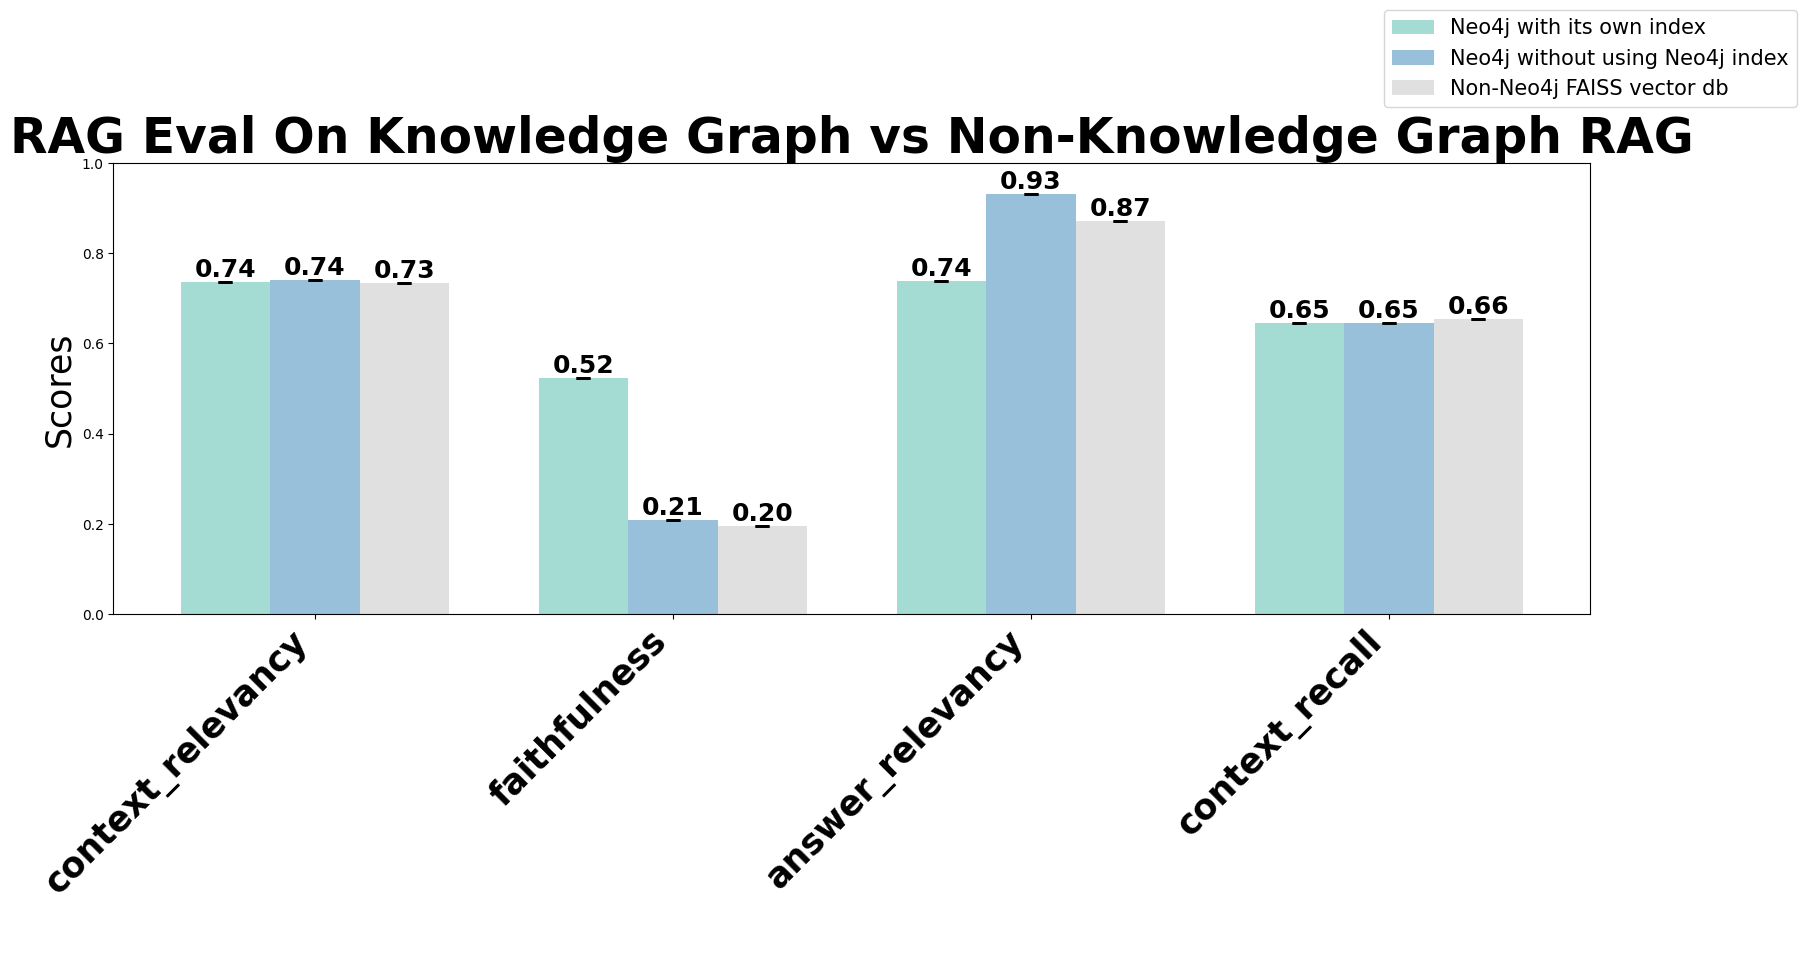

In [201]:
# Plot for N = 100
plot_results(results)

In [145]:
# with respect to N
print(len(ground_truth2))

100
